# Бутстрэп


Мы хотим получить какое-то представление о точности нашей оценки: качества модели, корреляции между двумя переменными и т.д. И мы не знаем, как распределена характеристика, которую мы оцениваем.

Есть много подходов к тому, как получить такую оценку, и один из них — бутстрэп.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L03/out/bootstrap.png" width="600"/></center>




Что мы делаем:

1. Делаем из нашего исходного датасета N выборок такого же размера с повторениями.
2. Для каждой полученной выборки (обычно их называют **псевдовыборками**) считаем характеристику, для которой хотим получить оценку.
3. В результате такой процедуры получаем N значений характеристики. Строим гистограмму этих значений. Получаем примерное распределение нашей характеристики.
4. Можем построить 95% доверительный интервал для нашей характеристики. Для этого отрезаем 2.5% самых больших значений и самых малых.

Давайте попробуем сделать это на двух практических примерах.

Подробнее про [бутстрэп 🎓[article]](https://www.jstor.org/stable/2958830?typeAccessWorkflow=login&seq=1).

## Построение доверительного интервала для качества метрики



Мы хотим сравнить поведение двух моделей на тестовом датасете. Допустим, нас интересует F1-score.

Сгенерируем данные:

In [1]:
import numpy as np

size = 1500
y = np.random.choice([0, 1], size=size, replace=True)
print(f"shape y: {y.shape}")
print(f"First 10 values: {y[0:10]}")

shape y: (1500,)
First 10 values: [0 1 0 0 1 0 1 1 0 0]


Напишем функцию, которая имитирует поведение модели, угадывающей правильный класс в $p$ процентах случаев:

In [2]:
def guess_model(y_real, p):
    guessed = np.random.choice([True, False], size=size, replace=True, p=[p, 1 - p])
    y_pred = np.zeros_like(y_real)
    y_pred[guessed] = y_real[guessed]
    y_pred[~guessed] = 1 - y_real[~guessed]
    return y_pred

Пусть две модели обладают одинаковым качеством, а третья — лучшим:

In [3]:
model1 = lambda y: guess_model(y, p=0.7)
model2 = lambda y: guess_model(y, p=0.7)
model3 = lambda y: guess_model(y, p=0.75)

np.random.seed(0)
y_pred1 = model1(y)
y_pred2 = model2(y)
y_pred3 = model3(y)

Первый вариант — просто посчитать F1-score каждой модели и проранжировать их в соответствии с F1-score:

In [4]:
from sklearn.metrics import f1_score

qual1 = f1_score(y_true=y, y_pred=y_pred1)
qual2 = f1_score(y_true=y, y_pred=y_pred2)
qual3 = f1_score(y_true=y, y_pred=y_pred3)

print(f" qual1: {qual1:.3f}\n qual2: {qual2:.3f}\n qual3: {qual3:.3f}")

 qual1: 0.695
 qual2: 0.686
 qual3: 0.769


Нужная нам модель выбрана, но почему мы считаем различия между второй и третьей моделью значимыми, а между первой и второй — нет?

In [5]:
print(f"qual2 - qual1: {(qual2 - qual1):.3f}\nqual3 - qual2: {(qual3 - qual2):.3f}")

qual2 - qual1: -0.009
qual3 - qual2: 0.083


Такой способ (при помощи точечной оценки) может привести к ошибке, так как не дает нам судить о **значимости** отличий.

Существует много способов посчитать значимость данного отличия. Мы рассмотрим способ сравнения на основе bootstrap.

Способ состоит в применении бутстрэпа к предсказаниям модели и реальным меткам.

In [6]:
def bootstrap_metric(y_true, y_pred, metric_fn, samples_cnt=1000, random_state=42):
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for i in range(samples_cnt):
        poses = np.random.choice(y_true.shape[0], size=y_true.shape[0], replace=True)

        y_true_boot = y_true[poses]
        y_pred_boot = y_pred[poses]
        m_val = metric_fn(y_true_boot, y_pred_boot)
        b_metric[i] = m_val

    return b_metric

Так мы сможем получить распределение нашей оценки:

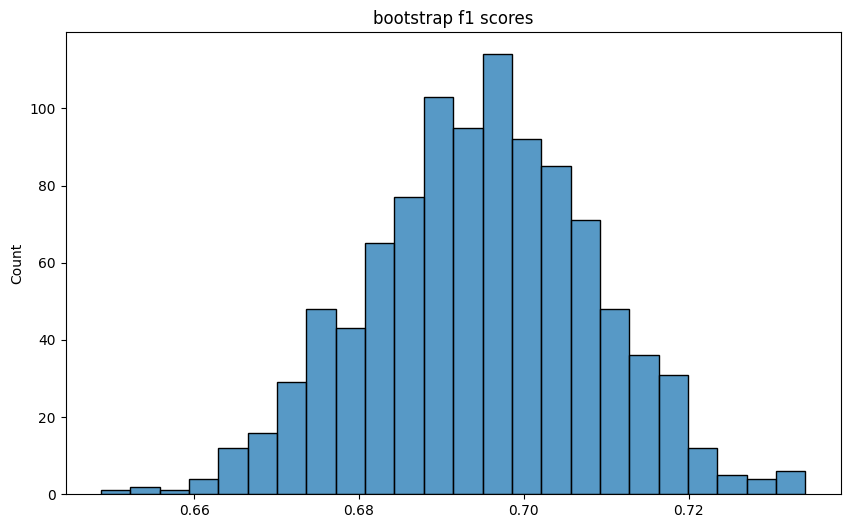

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt


boot_f1score_m1 = bootstrap_metric(y, y_pred1, metric_fn=f1_score)

# plot histogram of the obtained values:
plt.figure(figsize=(10, 6))
sns.histplot(boot_f1score_m1)
plt.title("bootstrap f1 scores")
plt.show()

На практие можем немного упростить функцию, уже понимая как она работает:

In [8]:
from sklearn.utils import resample

def bootstrap_metric(x, y, metric_fn, samples_cnt=1000, random_state=42):
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)

    for sample in range(samples_cnt):
        x_boot, y_boot = resample(x, y, replace=True, n_samples=x.shape[0])
        b_metric[sample] = metric_fn(x_boot, y_boot)

    return b_metric

Проверим что результат идентичный:

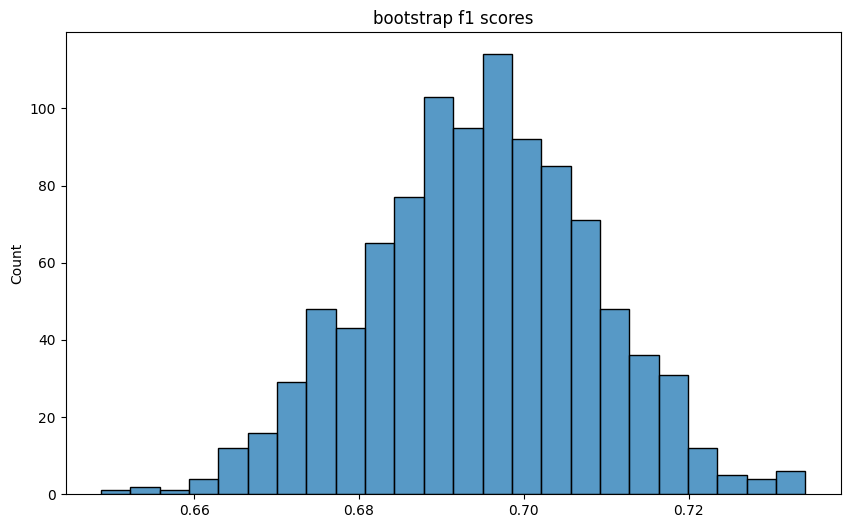

In [9]:
boot_f1score_m1 = bootstrap_metric(y, y_pred1, metric_fn=f1_score)

# plot histogram of the obtained values:
plt.figure(figsize=(10, 6))
sns.histplot(boot_f1score_m1)
plt.title("bootstrap f1 scores")
plt.show()

In [10]:
boot_f1score_m1 = bootstrap_metric(y, y_pred1, metric_fn=f1_score)
boot_f1score_m2 = bootstrap_metric(y, y_pred2, metric_fn=f1_score)
boot_f1score_m3 = bootstrap_metric(y, y_pred3, metric_fn=f1_score)

Построим 90% доверительный интервал качества для каждой модели:

In [11]:
alpha = 0.10
print(
    "F1 score for the 1st model: ",
    np.quantile(boot_f1score_m1, q=[alpha / 2, 1 - alpha / 2]),
)
print(
    "F1 score for the 2st model: ",
    np.quantile(boot_f1score_m2, q=[alpha / 2, 1 - alpha / 2]),
)
print(
    "F1 score for the 3st model: ",
    np.quantile(boot_f1score_m3, q=[alpha / 2, 1 - alpha / 2]),
)

F1 score for the 1st model:  [0.67210774 0.71686071]
F1 score for the 2st model:  [0.6615266  0.70746974]
F1 score for the 3st model:  [0.74965229 0.78937647]


Теперь мы видим, что доверительные интервалы для качества первой и второй модели практически одинаковы, в то время как доверительный интервал для качества третьей модели от них сильно отличается и не пересекается.

Можем построить боксплот ([box-plot 📚[wiki]](https://ru.wikipedia.org/wiki/%D0%AF%D1%89%D0%B8%D0%BA_%D1%81_%D1%83%D1%81%D0%B0%D0%BC%D0%B8)):

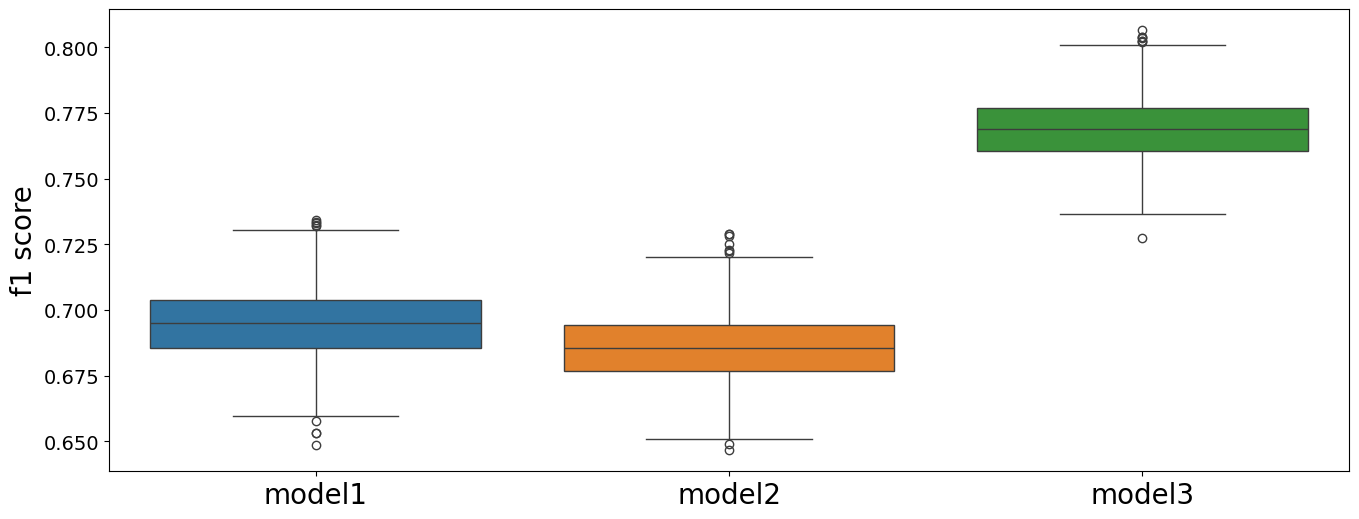

In [12]:
import pandas as pd


plt.figure(figsize=(16, 6))
sns.boxplot(
    data=pd.DataFrame(
        {
            "model1": boot_f1score_m1,
            "model2": boot_f1score_m2,
            "model3": boot_f1score_m3,
        }
    )
)
plt.ylabel("f1 score", size=20)
plt.tick_params(axis="both", which="major", labelsize=20)
plt.yticks(fontsize=14)
plt.show()

Мы могли бы использовать и тест [Манна — Уитни 📚[wiki]](https://ru.wikipedia.org/wiki/U-%D0%BA%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9_%D0%9C%D0%B0%D0%BD%D0%BD%D0%B0_%E2%80%94_%D0%A3%D0%B8%D1%82%D0%BD%D0%B8):

In [13]:
from scipy.stats import mannwhitneyu

statistic_m1_m2, p_value_m1_m2 = mannwhitneyu(boot_f1score_m1, boot_f1score_m2)
statistic_m1_m3, p_value_m1_m3 = mannwhitneyu(boot_f1score_m1, boot_f1score_m3)
statistic_m2_m3, p_value_m2_m3 = mannwhitneyu(boot_f1score_m2, boot_f1score_m3)

# fmt: off
print(f"m1 and m2 Mann–Whitney statistic: {statistic_m1_m2:<10} p-value:{p_value_m1_m2}")
print(f"m1 and m3 Mann–Whitney statistic: {statistic_m1_m3:<10} p-value:{p_value_m1_m3}")
print(f"m2 and m3 Mann–Whitney statistic: {statistic_m2_m3:<10} p-value:{p_value_m2_m3}")
# fmt: on

m1 and m2 Mann–Whitney statistic: 685018.5   p-value:1.4657888434544085e-46
m1 and m3 Mann–Whitney statistic: 10.0       p-value:0.0
m2 and m3 Mann–Whitney statistic: 3.0        p-value:0.0


Видим, что результат идентичен. В дальнейшем мы будем использовать только графики для оценки, но на практике полезно использовать несколько способов, чтобы избежать ошибочных суждений.

Рассмотрим на другом примере, используя данные о людях с наличием или отсутствием сердечных заболеваний. Загрузим датасет [Heart Disease 🛠️[doc]](https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset).

In [16]:
heart_dataset = pd.read_csv(
    "https://ml.gan4x4.ru/msu/datasets/heart.csv"
)
heart_dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [17]:
from sklearn.model_selection import train_test_split

x = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"] > 0
x_train, x_test, y_train, y_test = train_test_split(x, y.values, random_state=42)

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

logr_model = GridSearchCV(
    LogisticRegression(solver="liblinear", max_iter=100000),
    {"penalty": ("l1", "l2"), "C": [0.01, 0.1, 1, 10, 100]},
).fit(x_train, y_train)

# few objects in the leaf - poor estimates of class probabilities - the model is overfitting
dt_model = GridSearchCV(
    DecisionTreeClassifier(),
    {"max_depth": [1, 3, 5, 7, 10], "min_samples_leaf": [1, 3, 5, 10]},
).fit(x_train, y_train)

In [19]:
from sklearn.metrics import average_precision_score  # PR-AUC

y_pred1 = logr_model.predict_proba(x_test)[:, 1]
y_pred2 = dt_model.predict_proba(x_test)[:, 1]

qual1 = average_precision_score(y_true=y_test, y_score=y_pred1)
qual2 = average_precision_score(y_true=y_test, y_score=y_pred2)

In [20]:
print(f"Logistic regression pr-auc: {qual1:.03f}")
print(f"DecisionTreeClassifier pr-auc: {qual2:.03f}")

Logistic regression pr-auc: 0.902
DecisionTreeClassifier pr-auc: 0.801


Теперь подсчитаем бутстрэп-оценки. Обратите внимание на то, что теперь мы передаем не предсказания, а вероятности.

In [21]:
boot_score_logreg = bootstrap_metric(y_test, y_pred1, metric_fn=average_precision_score)
boot_score_dt = bootstrap_metric(y_test, y_pred2, metric_fn=average_precision_score)

alpha = 0.10
print(
    "Logistic regression pr-auc 90%-ci: ",
    np.quantile(boot_score_logreg, q=[alpha / 2, 1 - alpha / 2]),
)
print(
    "DecisionTreeClassifier pr-auc 90%-ci:",
    np.quantile(boot_score_dt, q=[alpha / 2, 1 - alpha / 2]),
)

Logistic regression pr-auc 90%-ci:  [0.8276533  0.97115084]
DecisionTreeClassifier pr-auc 90%-ci: [0.70049707 0.90513571]


Видим, что дерево решений уступает по качеству логистической регрессии.

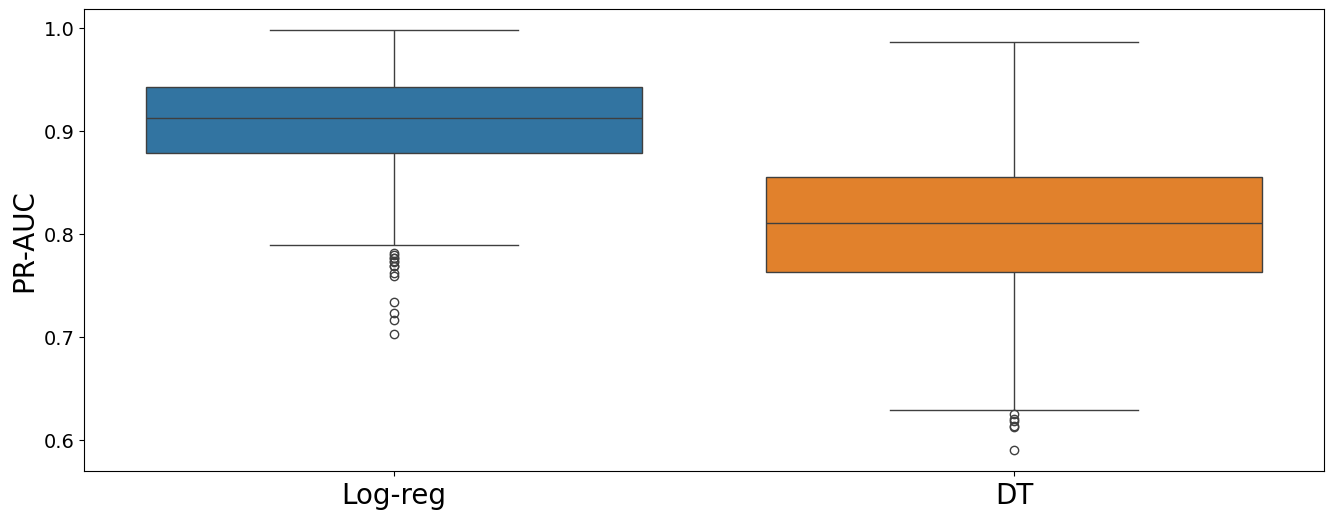

In [22]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=pd.DataFrame({"Log-reg": boot_score_logreg, "DT": boot_score_dt}))
plt.ylabel("PR-AUC", size=20)
plt.xlabel("", size=20)
plt.tick_params(axis="both", which="major", labelsize=20)
plt.yticks(fontsize=14)
plt.show()